# Example: signals

This notebook illustrates how to work with the `signal1d` class. In particular we illustrate
* sub-sampling onto a lower sampling rtae
* time shifting


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Imports etc.
import sys
sys.path.append("/home/rkube/repos/d3d_loaders")

from d3d_loaders.signal1d import signal_pinj, signal_ae_prob, signal_neut
from d3d_loaders.d3d_loaders import D3D_dataset

import h5py
import torch
import numpy as np
import logging
import pickle
import time
from math import ceil

import logging

from os.path import join

import matplotlib.pyplot as plt

In [4]:
# Parameters for signal_1d class
shotnr = 169113     # Shot number
t0 = 0.001          # Start time in shot. Use something larger than 0 to avoid rounding errors
t1 = 4000.0         # End time in the shot

# Parameters for hdf5 file loading
data_path = "/projects/EKOLEMEN/aza_lenny_data1"
tsample = 2.0   # This is the desired sample spacing to be used in the dataloader

### Instantiate a signal for Pinj and plot it

Now we instantiate a signal that contains the injected power. It will be defined on the interval [t0:t1] and uses a sampling rate of tsample=2.0 ms.

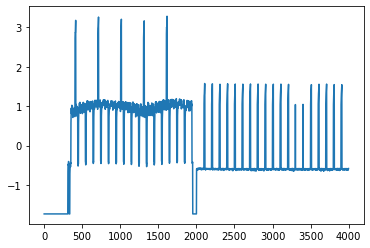

In [5]:
# Instantiate a signal for the Pinj data
sig_pinj = signal_pinj(shotnr, t0, t1, tsample)


# Plot the signal. The values are standardized (zero mean, unit std)
# A time-base for the signal can be constructed like this
tb_pinj = np.arange(t0, t1, tsample)
plt.plot(tb_pinj, sig_pinj.data.numpy())

Next, let us compare the data contained in the `signal` to the raw data in the hdf5 class.
For this, we re-define the `get_num_n_samples` method from `signal1d` and copy-and-paste the data loading code below.

In [6]:
# get_num_n_samples calculates 
# 1. The number of samples in the signal as sampled originally by dt
# 2. The up-sampling factor for the original sampling dt to the desired sample spacing tsample

def get_num_n_samples(dt):
        num_samples = int(ceil((t1 - t0) / dt))
        nth_sample = int(ceil(tsample / dt))
        
        return num_samples, nth_sample

In [7]:
fp_pinj = h5py.File(join(data_path, "template", f"{shotnr}_pinj.h5")) 
# Fetch the time-base from the h5 file
tb_pinj = torch.tensor(fp_pinj["pinjf_15l"]["xdata"][:])
# Calculate the sample spacing using data from the h5 file.
# In practice this will be a  odd number. We usually round it
dt0 = (tb_pinj[1:] - tb_pinj[:-1]).mean()     
dt = 1e-2
print(f"Average sample spacing: {dt0}. We are using {dt} instead.")

# Get total number of samples and desired sub-sample spacing
num_samples, nth_sample = get_num_n_samples(dt)
print(f"num_samples = {num_samples}, nth_sample = {nth_sample}")

# Find the first element of the time base
t0_idx = torch.argmin(torch.abs(tb_pinj - t0))

# Slice data from the h5 file and store
pinj_data = sum([torch.tensor(fp_pinj[k]["zdata"][:])[t0_idx:t0_idx + num_samples:nth_sample] for k in fp_pinj.keys()])
pinj_data_all = sum([torch.tensor(fp_pinj[k]["zdata"][:]) for k in fp_pinj.keys()])
fp_pinj.close()

Average sample spacing: 0.009999999776482582. We are using 0.01 instead.
num_samples = 400000, nth_sample = 200


Finally, we visualize the sub-sampling that `signal1d` performs internally. Right now sub-sampling is performed by down-sampling, i.e. taking every n-th sample and no bounds checking is performed. In the future, we may wish to use linear interpolation.

Text(0, 0.5, '∑ Pinj [Watt]')

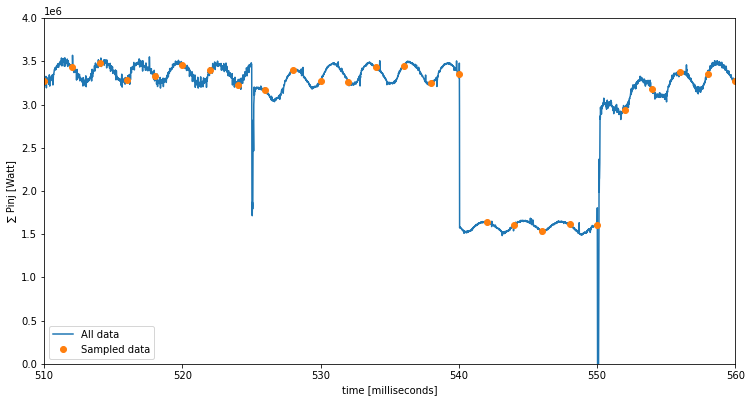

In [10]:
plot_idx_all = tb_pinj < 2000

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.plot(tb_pinj[plot_idx_all], pinj_data_all[plot_idx_all], '-', label="All data")
ax.plot(np.arange(t0, t1, tsample), sig_pinj.data * sig_pinj.data_std + sig_pinj.data_mean, 'o', label="Sampled data")

ax.set_xlim(510.0, 560)
ax.set_ylim(0, 4e6)

ax.legend(loc="lower left")
ax.set_xlabel("time [milliseconds]")
ax.set_ylabel("∑ Pinj [Watt]")

## Example: time-shifting

To perform predictions, time series shifted from the future are required. This is achieved by setting `tshift` in the constructor of a signal. 
The example below shows how to fetch signals that are time-shifted. They are plotted against a signal with no time shift. The plot shows that the shifted signals feature samples from a future time earlier than the un-shifted signal.

In [11]:
# Generate signals that are shifted into the future
sig_pinj_10 = signal_pinj(shotnr, t0, t1, tsample, tshift=10.0)
sig_pinj_20 = signal_pinj(shotnr, t0, t1, tsample, tshift=20.0)
sig_pinj_50 = signal_pinj(shotnr, t0, t1, tsample, tshift=50.0)

sig_list = [sig_pinj, sig_pinj_10, sig_pinj_20, sig_pinj_50]

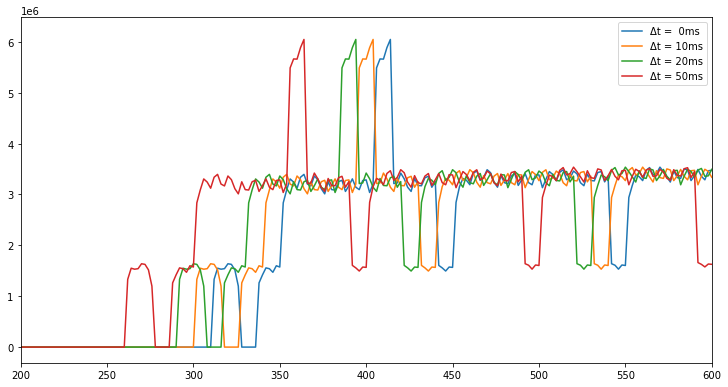

In [12]:
fig2 = plt.figure(figsize=(12, 6))
ax2 = fig2.add_axes([0.1, 0.1, 0.8, 0.8])

shift_list = [0, 10, 20, 50]
for sig, shift in zip(sig_list, shift_list):
    ax2.plot(np.arange(t0, t1, tsample), sig.data * sig.data_std + sig.data_mean, label=f"Δt = {shift:2d}ms")
    
ax2.legend(loc="upper right")
ax2.set_xlim((200, 600))

ax.set_xlabel("time [milliseconds]")
ax.set_ylabel("∑ Pinj [Watt]");

## Example: Change in Alfven-Eigenmode probability




In [15]:
sig_ae_t0 = signal_ae_prob(shotnr, t0, t1, tsample, tshift=0.0)
sig_ae_dt = signal_ae_prob(shotnr, t0, t1, tsample, tshift=100.0)

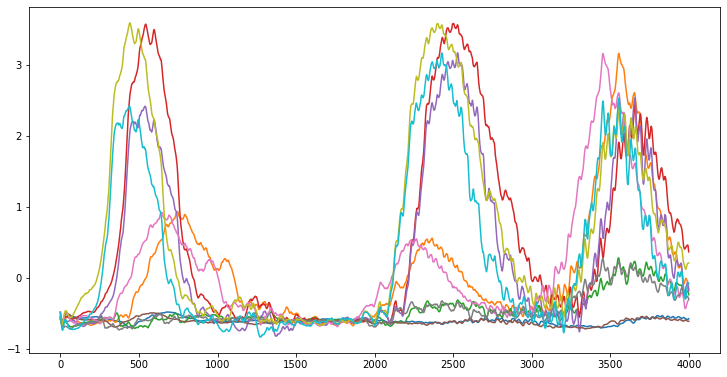

In [16]:
fig3 = plt.figure(figsize=(12, 6))
ax3 = fig3.add_axes([0.1, 0.1, 0.8, 0.8])

ax3.plot(np.arange(t0, t1, tsample), sig_ae_t0.data)
ax3.plot(np.arange(t0, t1, tsample), sig_ae_dt.data)

In [20]:
data = ((sig_ae_dt.data * sig_ae_dt.data_std) + sig_ae_dt.data_mean) - ((sig_ae_t0.data * sig_ae_t0.data_std) + sig_ae_t0.data_mean) 
data_mean = data.mean()
data_std = data.std()
data_norm = (data - data_mean) / data_std

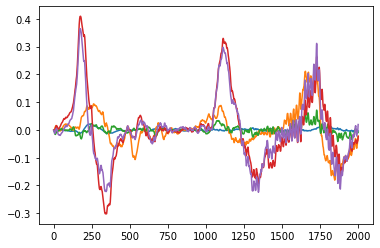

In [21]:
plt.plot(data)

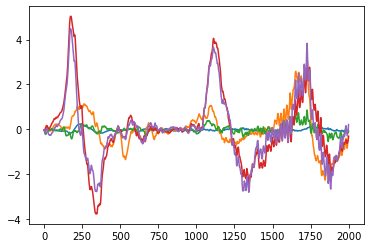

In [22]:
plt.plot(data_norm)